# Subreddit Classification with Natural Language Processing

## Modeling with a Support-Vector Machine

*Author: Grace Campbell*

#### Project Directory
1. Data Preparation 
    - [Data Gathering](http://localhost:8889/notebooks/projects/project_3/data-gathering.ipynb)
    - [Exploratory Data Analysis](http://localhost:8889/notebooks/projects/project_3/exploratory-data-analysis.ipynb)
2. Modeling
    - [Naive Bayes](http://localhost:8889/notebooks/projects/project_3/modeling-naive-bayes.ipynb)
    - [$k$-Nearest Neighbors](http://localhost:8889/notebooks/projects/project_3/modeling-knn.ipynb)
    - *Support-Vector Machine*

### Model Introduction

In this notebook, I will be modeling with `SVC`, a support-vector machine for classification. Support-vector machines are representations of example data in space, **linearly separated** into classes by a clear gap that is as wide as possible. They map new example data to that space and predict a class based on which side of the gap a point falls. ([Source](https://en.wikipedia.org/wiki/Support-vector_machine))

If the classes are **not** linearly separable, the support-vector machine uses the *kernel trick*, a method that transforms the data and forces them into higher dimensions so the classes **are** linearly separable. The easiest way to understand this is with the following image:

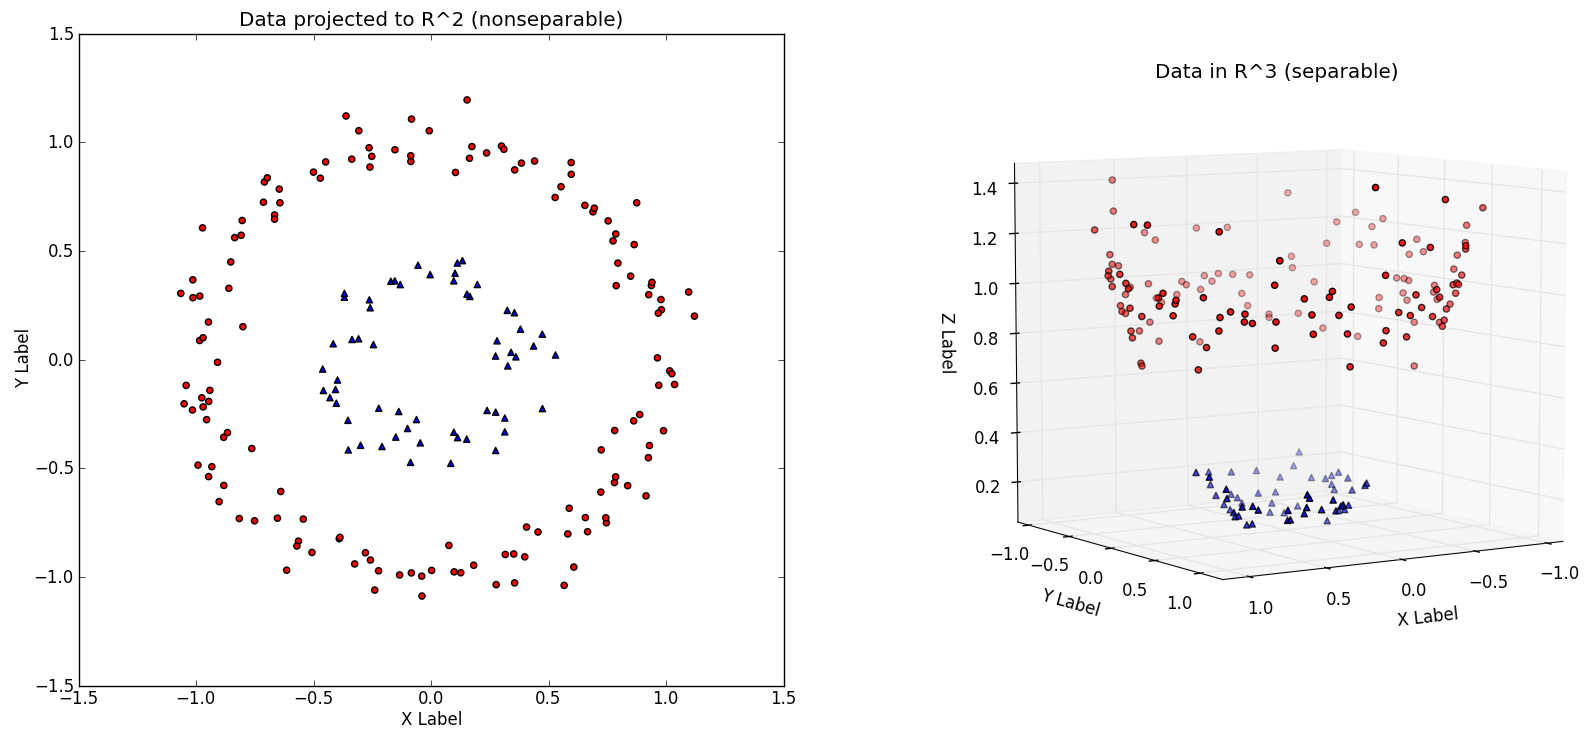 [Image source](https://towardsdatascience.com/understanding-the-kernel-trick-e0bc6112ef78)

The figure on the left shows the data in two dimensions, not linearly separable. The figure on the right shows that same data, transformed into a three-dimensional space so that it can be separated by a hyperplane.

### Modeling Strategy

Before I can begin modeling, I need to turn my text data into numeric data using `TfidfVectorizer`. This transformer will create a matrix of values, where the columns represent every word that appears in the corpus, and the rows represent each document in the corpus. The values are TFIDF statistics for each word in a document.

TFIDF stands for "term frequency-inverse document frequency" (**term frequency**: the number of times a word occurs in a document; **inverse document frequency**: an inverse function of the number of documents that contain the term). According to [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), "[t]he tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general."

Both of these methods have hyperparameters that can be tuned to optimize model performance, so I will perform a grid search using a pipeline with `TfidfVectorizer` and `SVC` to find the best parameters for both in the context of one another.

The grid search will test 3 different `TfidfVectorizer` hyperparameters:
1. `max_features`: how many features to extract (chosen by highest total frequency)
2. `min_df`: the minimum number of documents in which a feature must appear
3. `max_df`: the maximum percentage of documents in which a feature can appear

and 2 different `SVC` hyperparameters:
1. `C`: controls how much the model regularizes the boundary that is fit between classes
2. `kernel`: how the kernel trick is performed (how the data is forced into higher dimensions)

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from tokenizer import token_func

df = pd.read_csv('./materials/titles.csv')

In [2]:
# Creating X and y
X = df['title']
y = df['is_onion']

# Train-test splitting (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [3]:
# Instantiating a pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer(tokenizer=token_func)),
    ('svc', SVC(gamma='scale'))
])

# Hyperparameters to search over
params = {
    'tvec__max_features': [None, 1000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.9, 1.0],
    'svc__C': [10, 30],
    'svc__kernel': ['rbf', 'poly']
}

# Fitting the grid search
grid = GridSearchCV(pipe, params, cv=3)
grid.fit(X_train, y_train);

In [4]:
grid.best_score_

0.8213984835720304

In [5]:
# Which parameters did the grid search choose?
grid.best_params_

{'svc__C': 10,
 'svc__kernel': 'rbf',
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 2}

For `TfidfVectorizer`, the grid search decided:

- `max_features` should be None
    - I will have to investigate how many features are kept in the model when there is no maximum. I do not want more features than I have rows in `X_train` (to prevent collinearity), so I may have to set the `max_features` anyway, regardless of this grid search result.


- `min_df` should be 2
    - This means that a word must appear in at least 2 documents for it to be considered in the model.


- `max_df` should be 0.9, meaning a feature will not be included in the model if it appears in more than 90% of the documents
    - Since I eliminated stopwords from the tokens, there most likely will not be many (if any) words that show up in more than 90% of the titles.
    
For `SVC`, the grid search decided:

- `C` should be 10
    - A larger value of `C` means less regularization, and a more perfect classification of the data, which means there more chance of overfitting the model. However, I think 10 is low enough that the risk of overfitting is relatively small.
  
  
  
- `kernel` should be `rbf`, or 'radial basis kernel'
    - This kernel trick works well with circular or spherical data, and is the default kernel trick for `SVC` if none is specified.

### Transforming `X` Using Best Parameters

As I suspected, not setting a value for `max_features` in the `TfidfVectorizer` kept more features in `X_train` than there are rows. For the final transformation, I will set `max_features` equal to 1187 (the number of rows) so the number of features does not exceed the number of rows.

In [6]:
tvec = TfidfVectorizer(tokenizer=token_func, max_features=1187, min_df=2, max_df=0.9)

tvec.fit(X_train)

X_train_t = pd.DataFrame(tvec.transform(X_train).todense(), columns=tvec.get_feature_names())
X_test_t  = pd.DataFrame(tvec.transform(X_test).todense(), columns=tvec.get_feature_names())

### Running the Optimized Model

In [7]:
svc = SVC(C=10, kernel='rbf', gamma='scale')
svc.fit(X_train_t, y_train)

y_pred = svc.predict(X_test_t)

In [8]:
# Accuracy score
svc.score(X_test_t, y_test)

0.8787878787878788

In [9]:
# Confusion Matrix + other metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f'True Positives: {tp}')
print(f'False Negatives: {fn}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}\n')
print(f'Sensitivity: {tp/(tp+fn)}')
print(f'Specificity: {tn/(tn+fp)}')

True Positives: 220
False Negatives: 17
True Negatives: 128
False Positives: 31

Sensitivity: 0.9282700421940928
Specificity: 0.8050314465408805


### Interpretation of Results

The grid search found that `max_features` should be None to optimize the model's performance. However, without a feature limit, the model had more features than rows after vectorization. I had to reduce `max_features` to 1187, the number of rows in `X_train`, to reduce collinearity. To get the highest possible accuracy from this model, I would need to gather more data so that the model could use more features to make predictions.

The baseline accuracy score for the data is the score I would get if I predicted the majority class for every data point. The majority class here, /r/TheOnion, holds around 60% of the data. If I were to predict that every document in the data belonged to /r/TheOnion, I would get an accuracy score of 60%. That is to say, if a model does not predict subreddit membership with greater than 60% accuracy, then it is not a very good model.

The model's accuracy score is 87.9%, which is well above the baseline score of 60%. This means that the model correctly predicted the class 87.9% of the time. The model has very high sensitivity at 92.9%, meaning that 92.9% of the posts that were actually from /r/TheOnion were correctly predicted to be from /r/TheOnion. The model has lower specificity, 80.5%, which means that 80.5% of posts that belong to /r/News were correctly predicted to be from /r/News.

In a real-world application, it is equally important to me that this model be able to correctly predict when a post is satirical **and** when it is real. The positive class in this case is does not hold more weight than the negative class, therefore I would rather the model be very accurate than very sensitive or very specific. This model, however, is all three, which means that for my purposes it is a great model.